In [43]:
import os
from functools import partial

os.environ["JAX_ENABLE_X64"] = "True"

import jax.numpy as jnp
import typer
from jax import Array, jit, random, vmap
from jax._src.prng import PRNGKeyArray

from bpd import DATA_DIR
from bpd.draw import draw_exponential
from bpd.io import save_dataset
from bpd.likelihood import gaussian_image_loglikelihood
from bpd.pipelines import pipeline_interim_samples_one_galaxy
from bpd.prior import interim_gprops_logprior
from bpd.sample import (
    get_target_images,
    get_true_params_from_galaxy_params,
    sample_galaxy_params_skew,
)
from bpd.utils import DEFAULT_HYPERPARAMS, MAX_N_GALS_PER_GPU, process_in_batches

import matplotlib.pyplot as plt 

import numpy as np 

In [2]:
from ornax.hmc import ensemble_hmc

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
def _init_fnc(key: PRNGKeyArray, *, data: Array, true_params: dict):
    image = data
    assert image.ndim == 2
    assert image.shape[0] == image.shape[1]
    flux = image.sum()

    k1, k2, k3, k4, k5, k6 = random.split(key, 6)

    _lf = jnp.log10(flux)
    lf = random.uniform(k1, shape=(), minval=_lf - 0.01, maxval=_lf + 0.01)

    tlhlr = true_params["lhlr"]
    lhlr = random.uniform(k2, shape=(), minval=tlhlr - 0.015, maxval=tlhlr + 0.015)

    te1 = true_params["e1"]
    e1 = random.uniform(k3, shape=(), minval=te1 - 0.1, maxval=te1 + 0.1)

    te2 = true_params["e2"]
    e2 = random.uniform(k4, shape=(), minval=te2 - 0.1, maxval=te2 + 0.1)
    return {
        "lf": lf,
        "lhlr": lhlr,
        "e1": e1,
        "e2": e2,
        "dx": random.uniform(k5, shape=(), minval=-0.1, maxval=0.1),
        "dy": random.uniform(k6, shape=(), minval=-0.1, maxval=0.1),
    }

In [26]:
def initialize_params(key, image, true_params):
    return _init_fnc(key, data=image, true_params=true_params)

In [27]:
seed = 42 
n_gals: int = 100
n_samples_per_gal: int = 300
sigma_e_int: float = 0.3
g1: float = 0.02
g2: float = 0.0
slen: int = 63
fft_size: int = 256
background: float = 1.0

_params_order = ('lf', 'lhlr', 'dx', 'dy', 'e1', 'e2',)

In [28]:
rng_key = random.key(seed)
pkey, nkey, gkey = random.split(rng_key, 3)

In [29]:

# galaxy parameters from prior
galaxy_params = sample_galaxy_params_skew(
    pkey, n=n_gals, g1=g1, g2=g2, **DEFAULT_HYPERPARAMS
)
assert galaxy_params["x"].shape == (n_gals,)
assert galaxy_params["e1"].shape == (n_gals,)

# now get corresponding target images
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
draw_params["hlr"] = 10 ** draw_params.pop("lhlr")
target_images = get_target_images(
    nkey, draw_params, background=background, slen=slen, draw_type="exponential"
)
assert target_images.shape == (n_gals, slen, slen)

# interim samples are on 'sheared ellipticity'
true_params = vmap(get_true_params_from_galaxy_params)(galaxy_params)
true_params["dx"] = jnp.zeros_like(true_params["x"])
true_params["dy"] = jnp.zeros_like(true_params["y"])
fixed_params = {
    "x": true_params.pop("x"),
    "y": true_params.pop("y"),
}


In [30]:
true_params['e1'].shape

(100,)

In [31]:
from bpd.prior import ellip_prior_e1e2
from jax.scipy import stats



def logprior_flat(
    x: Array,
    *,
    sigma_e: float,
    sigma_x: float = 0.5,  # pixels
    flux_bds: tuple = (-1.0, 9.0),
    hlr_bds: tuple = (-2.0, 1.0),
):
    assert x.shape == (6,)
    prior = jnp.array(0.0)
    lf, lhlr, dx, dy, e1, e2 = x

    f1, f2 = flux_bds
    prior += stats.uniform.logpdf(lf, f1, f2 - f1)

    h1, h2 = hlr_bds
    prior += stats.uniform.logpdf(lhlr, h1, h2 - h1)

    prior += stats.norm.logpdf(dx, loc=0.0, scale=sigma_x)
    prior += stats.norm.logpdf(dy, loc=0.0, scale=sigma_x)

    e1e2 = jnp.stack((e1, e2), axis=-1)
    prior += jnp.log(ellip_prior_e1e2(e1e2, sigma=sigma_e))

    return prior

In [32]:
def gaussian_image_loglikelihood_flat(
    x:Array,
    data: Array,
    fixed_params: dict[str, Array],
    *,
    draw_fnc,
    background: float,
):
    assert x.shape == (6,)
    assert data.ndim == 2
    _draw_params = {}
    lf, lhlr, dx, dy, e1, e2 = x

    _draw_params["x"] = dx + fixed_params["x"]
    _draw_params["y"] = dy + fixed_params["y"]
    _draw_params["f"] = 10 ** lf
    _draw_params["hlr"] = 10 ** lhlr
    _draw_params["e1"] = e1
    _draw_params["e2"] = e2
    model = draw_fnc(**_draw_params)
    likelihood_pp = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(background))
    return jnp.sum(likelihood_pp)


In [33]:
# setup prior and likelihood
_logprior = partial(
    logprior_flat,
    sigma_e=sigma_e_int,
)
_draw_fnc = partial(draw_exponential, slen=slen, fft_size=fft_size)
_loglikelihood = partial(
    gaussian_image_loglikelihood_flat,
    draw_fnc=_draw_fnc,
    background=background,
)

In [34]:
def my_logtarget(x:Array, *, data, fixed_params, logprior, loglikelihood):
    return logprior(x) + loglikelihood(x, data, fixed_params)
    

In [35]:
def run_ensemble_hmc(rng_key, data, init_positions, fixed_params, *, logprior, loglikelihood):

    _logtarget = partial(my_logtarget, data=data, fixed_params=fixed_params, logprior=logprior, loglikelihood=loglikelihood)
    chain, acc, loglike = ensemble_hmc(rng_key, _logtarget, n_dims=6, n_samples=1000, params_init=init_positions, verbose=False)

    return chain, acc, loglike

_pipe = partial(run_ensemble_hmc, logprior=_logprior, loglikelihood=_loglikelihood)

In [36]:
n_dims = 6 # number of parameters
n_walkers = max(2 * n_dims, 10)

In [37]:
init_key, run_key = random.split(gkey)

In [38]:
# vmap(initialize_params)(random.split(init_key, (n_gals,)), target_images, true_params)

In [39]:
_init_keys = random.split(init_key, (n_gals, n_walkers))
_init_vectorized = vmap(vmap(initialize_params, in_axes=(0,None, None)))
init_params = _init_vectorized(_init_keys, target_images, true_params)

In [40]:
init_params['e1'].shape, _params_order

((100, 12), ('lf', 'lhlr', 'dx', 'dy', 'e1', 'e2'))

In [41]:
init_params['lf'][0]

Array([2.65042952, 2.66264912, 2.66067957, 2.66793352, 2.66521762,
       2.66102399, 2.65600139, 2.66755406, 2.66321783, 2.66436271,
       2.66428985, 2.65486975], dtype=float64)

In [47]:
# convert to array in the correct order
_init_params_array = np.zeros((n_gals, n_walkers, 6))
for ii, k in enumerate(_params_order):
    _init_params_array[..., ii] = init_params[k]
    
_init_params_array = jnp.array(_init_params_array)
_init_params_array.shape, _init_params_array.devices()

((100, 12, 6), {CudaDevice(id=0)})

In [48]:
run_keys = random.split(run_key, n_gals)
run_keys.shape

(100,)

In [49]:
fixed_params['x'].shape

(100,)

# Sanity check and jit one example

In [50]:
pipe = jit(_pipe)

In [51]:
samples, _, _ = pipe(run_keys[0],
     target_images[0],
     _init_params_array[0],
     {k:v[0] for k,v in fixed_params.items()},
    )

In [53]:
samples.shape

(1000, 12, 6)

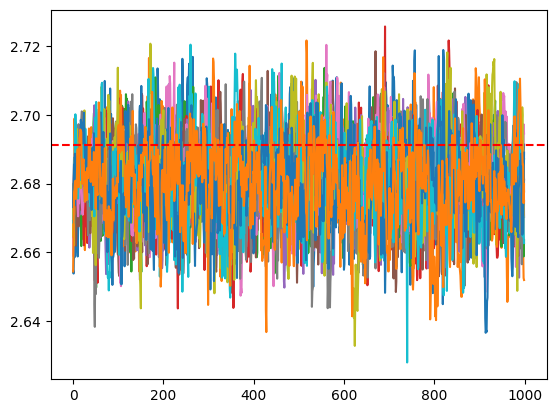

In [55]:
for ii in range(12):

    plt.plot(samples[:,ii, 0])
plt.axhline(true_params['lf'][0], c='r', ls='--')


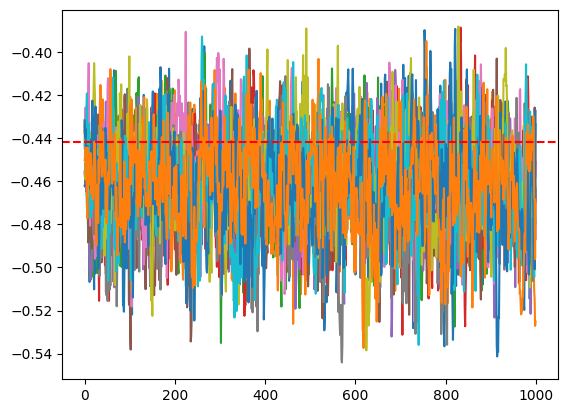

In [56]:
for ii in range(12):
    plt.plot(samples[:,ii, 1])
plt.axhline(true_params['lhlr'][0], c='r', ls='--')


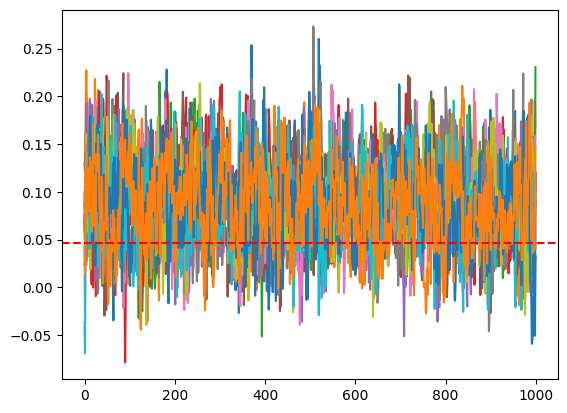

In [57]:
for ii in range(12):
    plt.plot(samples[:,ii, 4])
plt.axhline(true_params['e1'][0], c='r', ls='--')

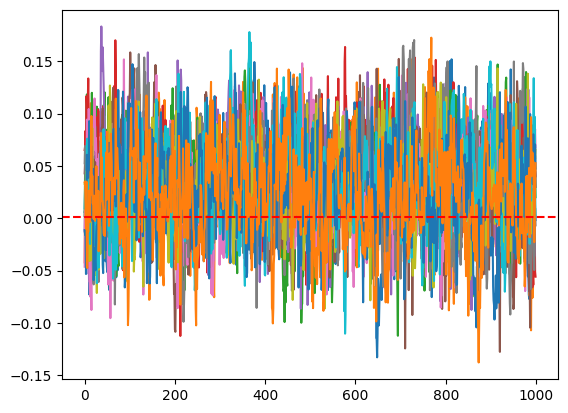

In [58]:
for ii in range(12):
    plt.plot(samples[:,ii, 5])
plt.axhline(true_params['e2'][0], c='r', ls='--')

# Vectorize

In [62]:
# samples, _ , _ = vmap(pipe)(run_keys[:10],
#      target_images[:10],
#      _init_params_array[:10],
#      {k:v[:10] for k,v in fixed_params.items()}
#     )


In [74]:
samples, _ , _ = vmap(pipe)(run_keys,
     target_images,
     _init_params_array,
     fixed_params,
    )
# > 5 min

In [75]:
samples.shape

(100, 1000, 12, 6)

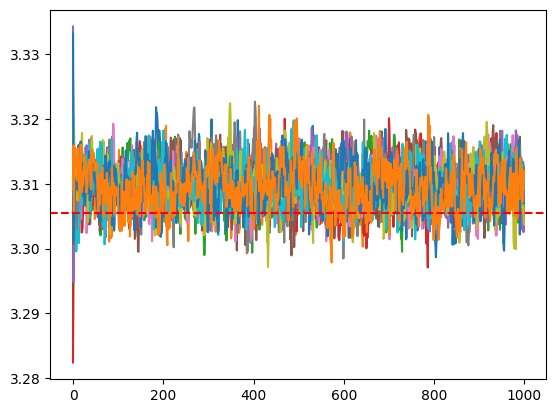

In [84]:

jj = 23
for ii in range(12):
    plt.plot(samples[jj, :,ii, 0])
plt.axhline(true_params['lf'][jj], c='r', ls='--')

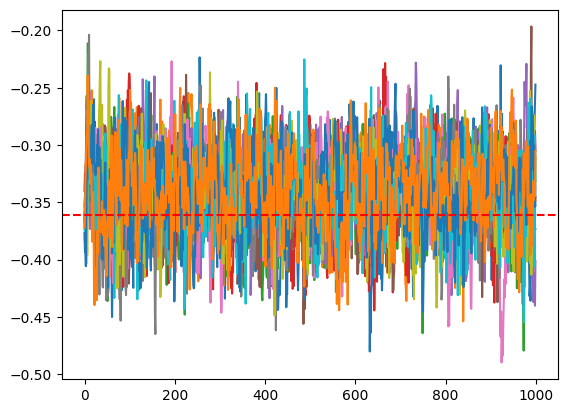

In [85]:
jj = 44
for ii in range(12):
    plt.plot(samples[jj, :,ii, 1])
plt.axhline(true_params['lhlr'][jj], c='r', ls='--')

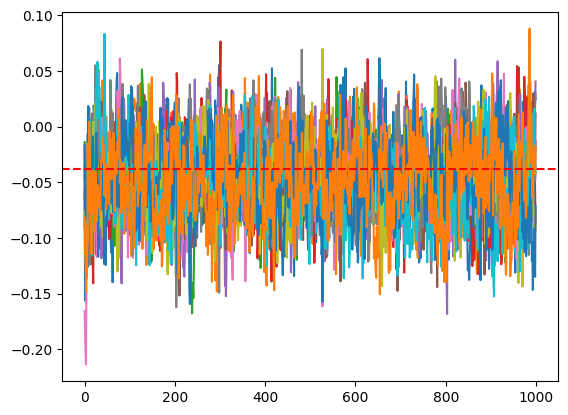

In [87]:

jj = 55
for ii in range(12):
    plt.plot(samples[jj, :,ii, 4])
plt.axhline(true_params['e1'][jj], c='r', ls='--')